In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

In [3]:
from Corrfunc.mocks import DDrppi_mocks, DDtheta_mocks
from Corrfunc.io import read_catalog
from Corrfunc.theory import DDrppi, DD
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf

In [6]:
cmass = np.load('../catalogue/cmass_z_cut.npy')
# random = np.load('../catalogue/random_new_test_apply_mask.npy')
random = np.load('../catalogue/cmass_random.npy')
# random = np.load('../catalogue/random_sample_quasar_narrow_z_cut.npy')
# random = random[:len(random)//2]

In [7]:
dis_cov_g = cosmos.angular_diameter_distance(cmass['z']).to(u.Mpc).value*(1+cmass['z'])*h
dis_cov_r = cosmos.angular_diameter_distance(random['z']).to(u.Mpc).value*(1+random['z'])*h

In [8]:
Nbins = 15
rp_bin = np.geomspace(3, 100, Nbins+1)

z = 0.55
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100
d_A = cosmos.angular_diameter_distance(z).to(u.Mpc).value
chi_l = d_A*(1+z)
theta_bins = rp_bin/h/(1+z)/d_A

pair counts

In [9]:
dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=40, binfile=rp_bin,
                   RA1=cmass['ra'], DEC1=cmass['dec'], CZ1=dis_cov_g, weights1=cmass['w'], is_comoving_dist=True)

In [10]:
rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=40, binfile=rp_bin,
                   RA1=random['ra'], DEC1=random['dec'], CZ1=dis_cov_r, weights1=random['w'], is_comoving_dist=True)

In [11]:
dr = DDrppi_mocks(
    autocorr=False, cosmology=1, nthreads=50, pimax=40, binfile=rp_bin, 
    RA1=cmass['ra'], DEC1=cmass['dec'], CZ1=dis_cov_g, weights1=cmass['w'], 
    RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
    is_comoving_dist=True)

In [12]:
Nd = len(cmass)
Nr = len(random)

result of $\xi(r_p, \pi)$

In [24]:
result = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd, dr, dr, rr)

Text(0, 0.5, '$\\log r_p$')

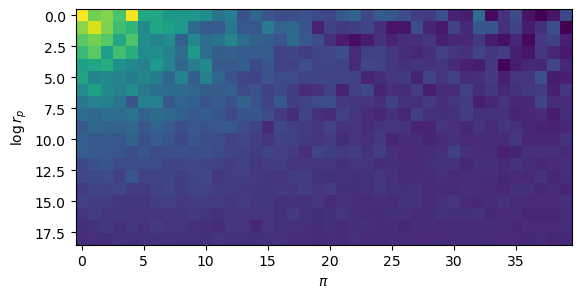

In [27]:
plt.imshow(result.reshape((15, 40)))
plt.xlabel('$\\pi$')
plt.ylabel('$\\log r_p$')

In [45]:
from scipy.interpolate import RegularGridInterpolator
rp = (rp_bin[1:]*rp_bin[:-1])**0.5
pi = np.arange(40)+0.5
func = RegularGridInterpolator((rp, pi), result.reshape((15, 40)), bounds_error=False, fill_value=None)

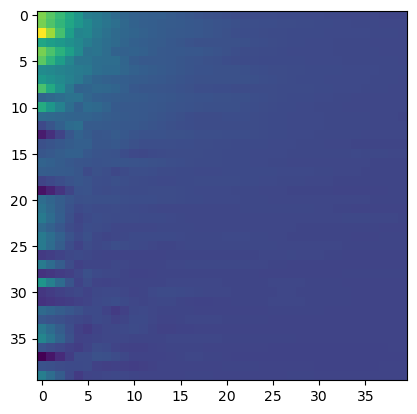

In [25]:
new_rp, new_pi = np.meshgrid(pi, pi)

plt.imshow(func((new_rp.flatten(), new_pi.flatten())).reshape(40, 40))

result of $w(r_p)$

In [13]:
w = convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=40, nrpbins=15)

[]

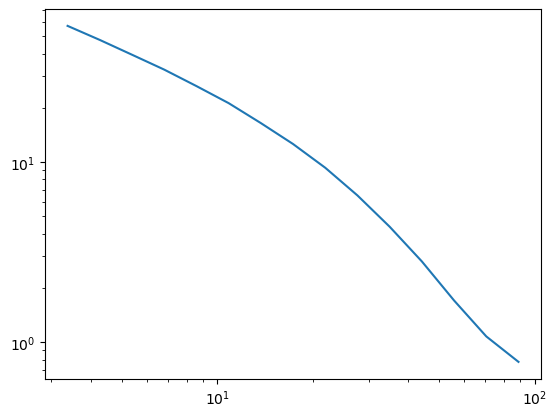

In [14]:
# plt.plot((rp_bin[:-1]*rp_bin[1:])**0.5, w_2)
plt.plot((rp_bin[:-1]*rp_bin[1:])**0.5, w)
plt.loglog()
# plt.ylim(1e-1, 1e2)
# plt.savefig('./fig/w_rp_new_2')

result of $w(\theta)$

In [20]:
theta_bins_deg = np.rad2deg(theta_bins)
dd_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg,
                         RA1=cmass['ra'], DEC1=cmass['dec'], weights1=cmass['w'])
dr_theta = DDtheta_mocks(autocorr=0, nthreads=50, binfile=theta_bins_deg, 
                         RA1=cmass['ra'], DEC1=cmass['dec'], weights1=cmass['w'],
                         RA2=random['ra'], DEC2=random['dec'], weights2=random['w'])
rr_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg, 
                         RA1=random['ra'], DEC1=random['dec'], weights1=random['w'])

In [21]:
w_theta = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd_theta, dr_theta, dr_theta, rr_theta)

In [22]:
dd_theta['npairs']/(Nd*(Nd-1)/2)/(rr_theta['npairs']/(Nr*(Nr-1)/2))-1

array([0.19830248, 0.19392385, 0.18952428, 0.18753108, 0.18763174,
       0.1880428 , 0.18485658, 0.18140508, 0.18143289, 0.17877037,
       0.17738491, 0.17561948, 0.17386099, 0.1720269 , 0.16967083])

[]

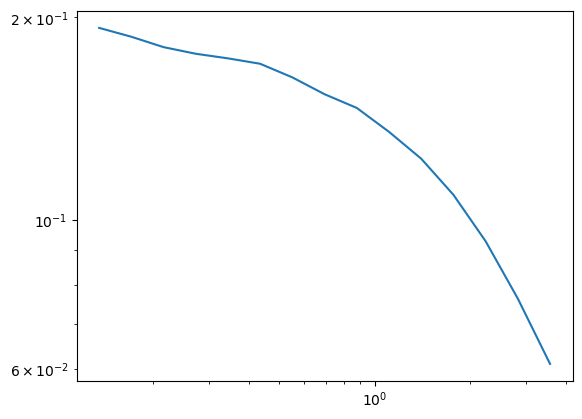

In [23]:
plt.plot((theta_bins_deg[1:]*theta_bins_deg[:-1])**0.5, w_theta)
plt.loglog()

tutorial

In [58]:
X, Y, Z = read_catalog()
N = len(X)
boxsize=420.0
rand_N = 3*N
seed = 42
np.random.seed(seed)
rand_X = np.random.uniform(0, boxsize, rand_N)
rand_Y = np.random.uniform(0, boxsize, rand_N)
rand_Z = np.random.uniform(0, boxsize, rand_N)
nthreads = 4
pimax = 40.0
nrpbins = 20
rpmin = 0.1
rpmax = 10.0
bins = np.linspace(rpmin, rpmax, nrpbins + 1)
autocorr = 1
DD_counts = DDrppi(autocorr, nthreads, pimax, bins,
                   X, Y, Z, boxsize=boxsize)
autocorr = 0
DR_counts = DDrppi(autocorr, nthreads, pimax, bins,
                   X, Y, Z,
                   X2=rand_X, Y2=rand_Y, Z2=rand_Z, boxsize=boxsize)
autocorr = 1
RR_counts = DDrppi(autocorr, nthreads, pimax, bins,
                   rand_X, rand_Y, rand_Z, boxsize=boxsize)
wp = convert_rp_pi_counts_to_wp(N, N, rand_N, rand_N,
                                DD_counts, DR_counts,
                                DR_counts, RR_counts,
                                nrpbins, pimax)


[]

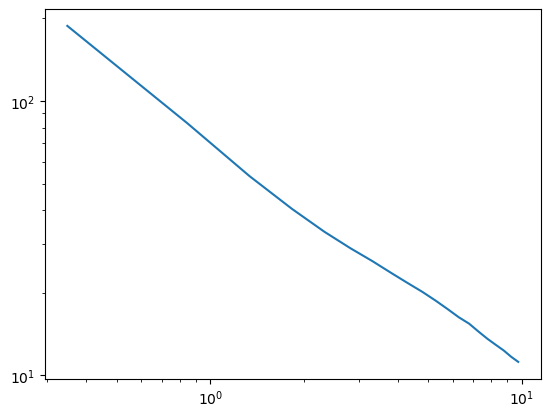

In [59]:
plt.plot((bins[1:]+bins[:-1])/2, wp)
plt.loglog()

In [34]:
nthreads = 2
rmin = 0.1
rmax = 15.0
nbins = 10
bins = np.linspace(rmin, rmax, nbins + 1)
autocorr = 1
DD_counts = dd(autocorr, nthreads, bins, X, Y, Z, boxsize=boxsize)
autocorr = 0
DR_counts = dd(autocorr, nthreads, bins,
               X, Y, Z,
               X2=rand_X, Y2=rand_Y, Z2=rand_Z, boxsize=boxsize)
autocorr = 1
RR_counts = dd(autocorr, nthreads, bins, rand_X, rand_Y, rand_Z,
               boxsize=boxsize)
cf = convert_3d_counts_to_cf(N, N, rand_N, rand_N,
                             DD_counts, DR_counts,
                             DR_counts, RR_counts)

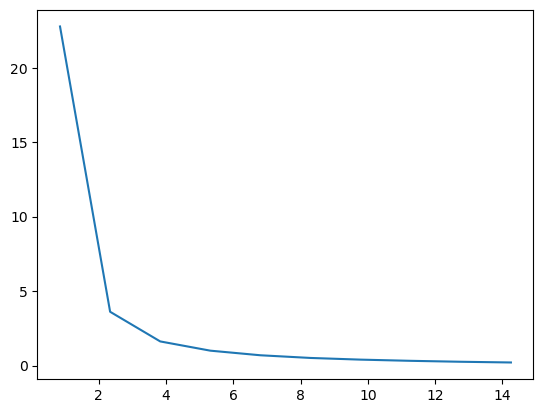

In [37]:
plt.plot((bins[1:]+bins[:-1])/2, cf)